In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
import matplotlib.ticker as ticker
%matplotlib inline

import torch
import gc
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
start_token = "_"
eos = '#'
MAX_LENGTH = 40

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x:  x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
s = "".join(data_pairs.word_norm)
tokens = np.sort(np.array(list(set(s))))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

# np.save('drive/diploma/vocabulary/tok2id.npy', tok2id) 

# np.save('drive/diploma/vocabulary/id2tok.npy', id2tok) 

There are {} tokens 48
Vocabular: #'-0123456789_абвгдежзийклмнопрстуфхцчшщъыьэюяё’


In [0]:
import re

set_morph = set()
for i in range(data_pairs.shape[0]):
  loc = re.split(",| ", data_pairs.morph_features_form.values[i])
  for elem in loc:
    set_morph.add(elem)
tokens_f = np.sort(np.array(list(set_morph)))

tok2id_f = dict(zip(tokens_f, np.arange(tokens_f.shape[0])))
# id2tok_f = dict(zip(np.arange(tokens.shape[0]), tokens))

# np.save('drive/diploma/vocabulary/tok2id_f.npy', tok2id_f) 

print ('There are {} tokens',len(tokens_f))

print('Vocabular: ' + "".join(tokens_f))

There are {} tokens 100
Vocabular: 1per2per3perADJFADJSADVBAbbrAdjxAf-pAnphAnumAproArchCOMPCONJCmp2CollCounDistDmnsErroFimpFixdGNdrGRNDGeoxHypoINFNINTJImpeImpxInfrInitInmxLitrMs-fNOUNNPRONUMRNameOrgnPRCLPREDPREPPRTFPRTSPatrPltmPossPrdxPrntQualQuesSgtmSlngSubxSuprSurnV-beV-biV-ejV-enV-eyV-ieV-oyV-shVERBVpreabltaccsactvanimdatvexclfemnfutrgen1gen2gentimpfimprinaninclindcintrloc1loc2loctmascms-fneutnomnpastperfplurprespssvsingtranvoct


In [0]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [0]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
print('\n'.join(data_pairs.word_form[:10]))
print(to_matrix(data_pairs.word_form[:10]))

ежа#
ежу#
ежа#
ежом#
еже#
ежи#
ежей#
ежам#
ежей#
ежами#
[[19 20 14  0  0  0]
 [19 20 33  0  0  0]
 [19 20 14  0  0  0]
 [19 20 28 26  0  0]
 [19 20 19  0  0  0]
 [19 20 22  0  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26 22  0]]


In [0]:
tok2id_f[eos] = 100

def to_matrix_f(words, max_len=None, pad=tok2id_f[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id_f.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
# Creating training and validation sets using an 80-20 split

indices = data_pairs.lex_id.unique()
np.random.seed(42)
np.random.shuffle(indices)
data_pairs.set_index("lex_id", inplace=True)
train = data_pairs.loc[indices[:int(0.8 * indices.shape[0])]]
input_train = train.drop("word_form", axis=1)
target_train = train.word_form.values

test = data_pairs.loc[indices[int(0.8 * indices.shape[0]):]]
input_test = test.drop("word_form", axis=1)
target_test = test.word_form.values

In [0]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data.word_norm.values[index], self.data.morph_features_form.values[index], self.target[index], self.data.morph_features_norm.values[index]

In [0]:
BATCH_SIZE = 512

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_data = pairs_Dataset(input_test, target_test)

test_batches = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [0]:
for batch in dataset:
    print(batch)
    print(batch[1])
    print([batch[3][i] + " " + batch[1][i] for i in range(len(batch[3]))])
    print(batch[3] + batch[1])
#     print(to_matrix_f(batch[1]))
    break

[('_специалистка#', '_продольно-поперечный#', '_тереса#', '_субстанциализирую#', '_внутрикнижный#', '_додержан#', '_назначивший#', '_бодря#', '_высмеивавшийся#', '_бутафорский#', '_прополз#', '_каверзничаю#', '_гиблый#', '_хрящеватый#', '_моющийся#', '_перегулял#', '_докапывавший#', '_фривольничаю#', '_причертивший#', '_подвинтивший#', '_ять#', '_презентующий#', '_наперчивавший#', '_поддетый#', '_ферзиковский#', '_допахивавшийся#', '_угодил#', '_оглушённый#', '_каджаран#', '_подкладной#', '_механицист#', '_обмыл#', '_антилимфоцитарный#', '_патентующий#', '_безглавый#', '_пеленавший#', '_концентрировавшийся#', '_лига#', '_язычковый#', '_выставной#', '_обмораживаемый#', '_заговорный#', '_приуменьшённый#', '_сибур#', '_бороздившийся#', '_верховодовы#', '_пряжинский#', '_лишавший#', '_обезвоживающий#', '_виннокислый#', '_госкоминтурист#', '_гермаген#', '_перлинь#', '_десенсибилизация#', '_бултыхание#', '_примечание#', '_зауживающийся#', '_савватеевич#', '_реверсивность#', '_оглашавший#', '

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, emb_size, output_size, morph_feat_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.morph_size = morph_feat_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.emb_size)
        self.attn = nn.Linear(self.hidden_size + self.emb_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.emb_size, self.hidden_size)
        
        self.embedding_morph = nn.Embedding(self.morph_size, self.emb_size)
        self.attn_morph = nn.Linear(self.hidden_size + self.emb_size * 11, 11)
        self.attn_combine_morph = nn.Linear(self.hidden_size + self.emb_size * 11, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(2 * self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, input_feat, feat_enc_out, morph_feat_hidden, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        output = torch.cat((embedded[0], attn_applied.squeeze()), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        embedded_morph = self.embedding_morph(input_feat).view(1, self.batch_size, -1)
        attn_weights_morph = F.softmax(
            self.attn_morph(torch.cat((embedded_morph[0], hidden[0]), 1)), dim=1)
        
        attn_applied = torch.bmm(attn_weights_morph.unsqueeze(1),
                                 feat_enc_out)
        output_morph = torch.cat((embedded_morph[0], attn_applied.squeeze()), 1)
        output_morph = self.attn_combine_morph(output_morph).unsqueeze(0)
        output_morph = F.relu(output_morph)
        
        output = torch.cat((output, output_morph), 2)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights, attn_weights_morph

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
teacher_forcing_ratio = 0.5

def train_batch(X, X_f, y, encoder, encoder_f, decoder, encoder_opt, encoder_f_opt, decoder_opt, criterion, lr, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_hidden_f = encoder_f.initHidden()
    
    encoder.train()
    encoder_f.train()
    decoder.train()
    
    encoder_opt.zero_grad()
    encoder_f_opt.zero_grad()
    decoder_opt.zero_grad()
    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    encoder_outputs_f = torch.zeros(BATCH_SIZE, 11, encoder.hidden_size, device=device)
    loss = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]
    for i in range(X_f.shape[1]):
        encoder_output_f, encoder_hidden_f = encoder_f(
            X_f[:, i], encoder_hidden_f)
        encoder_outputs_f[:, i] = encoder_output_f[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention, _ = decoder(
                decoder_input, X_f,  encoder_outputs_f, encoder_hidden_f, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, y[:, di])
            decoder_input = y[:, di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention, _ = decoder(
                decoder_input, X_f, encoder_outputs_f, encoder_hidden_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, y[:, di])

    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(encoder_f.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    encoder_opt.step()
    encoder_f_opt.step()
    decoder_opt.step()

    return loss.item()

In [0]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def test(encoder, encoder_f, decoder, criterion, test_batches, loss_log, acc_log):
    encoder.eval()
    encoder_f.eval()
    decoder.eval()
    for batch_num, batch in zip(trange(len(test_batches)), test_batches):
        encoder_hidden = encoder.initHidden()
        encoder_hidden_f = encoder_f.initHidden()
        max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
        X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
        X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
        y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
        
        max_length = X.shape[1]
        encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
        encoder_outputs_f = torch.zeros(BATCH_SIZE, 11, encoder.hidden_size, device=device)
        loss = 0
        acc = 0
        for i in range(X.shape[1]):
            encoder_output, encoder_hidden = encoder(
                X[:, i], encoder_hidden)
            encoder_outputs[:, i] = encoder_output[0]
            
        for i in range(X_f.shape[1]):
            encoder_output_f, encoder_hidden_f = encoder_f(
                X_f[:, i], encoder_hidden_f)
            encoder_outputs_f[:, i] = encoder_output_f[0]
            
        decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

        decoder_hidden = encoder_hidden
        decoder_pred = []
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention, _ = decoder(
                decoder_input, X_f, encoder_outputs_f, encoder_hidden_f, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, y[:, di])
            decoder_pred.append(decoder_input.cpu())
        res = np.vstack(decoder_pred).T
        pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
        true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
        acc = accuracy_score(pred_res, true_res)
        loss_log.append(float(loss) / X.shape[0])
        acc_log.append(acc)
    plot_history(loss_log, title="Test")
    plot_history(acc_log, title="Accuracy")
    print("Mean accuracy - {}".format(np.mean(acc_log)))
    return loss_log

def train(data, test_batches, encoder, encoder_f, decoder, encoder_optimizer, decoder_optimizer, encoder_f_optimizer, n_epochs, print_every=1, plot_every=1, lr=0.005, plot_losses=[]):
    start = time.time()
    loss_log = []
    acc_log = []
    criterion = nn.NLLLoss()
    lr_decay_base = 1 / 1.15
    m_flat_lr = 10.0
    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        loss = 0
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
            y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, X_f, y, encoder, encoder_f,
                     decoder, encoder_optimizer, encoder_f_optimizer, decoder_optimizer, criterion, lr)
            plot_losses.append(loss / X.shape[0])
        clear_output()
        gc.collect()
        print("Loss - {}".format(loss))
        print("Epoch - {}".format(epoch))
        plot_history(plot_losses, "Train")
        torch.save({
            'encoder1_state_dict': encoder.state_dict(),
            'encoder2_state_dict': encoder_f.state_dict(),
            'attn_decoder1_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'encoder_f_optimizer_state_dict': encoder_f_optimizer.state_dict(),
            'plot_losses':plot_losses,
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
            }, "drive/diploma/two_encoders_new/ADAM_two_encoders_unidir_GRU_{}".format(epoch))
    gc.collect()
    test(encoder, encoder_f, decoder, criterion, test_batches, loss_log, acc_log)
        

In [0]:
hidden_size = 256
emb_size = 50
learning_rate = 0.01
encoder1 = EncoderRNN(tokens.shape[0], hidden_size).to(device)
encoder2 = EncoderRNN(tokens_f.shape[0] + 1, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, emb_size, tokens.shape[0], tokens_f.shape[0] + 1, dropout_p=0.1).to(device)

encoder_optimizer = optim.Adam(encoder1.parameters())
decoder_optimizer = optim.Adam(attn_decoder1.parameters())
encoder_f_optimizer = optim.Adam(encoder2.parameters())

Loss - 0.09773392975330353
Epoch - 8


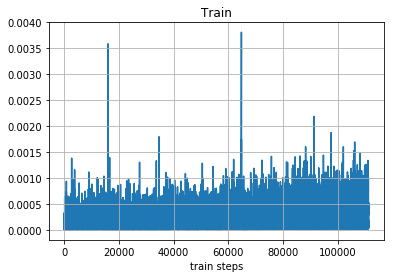

  1%|          | 62/7422 [00:14<28:33,  4.29it/s]

In [0]:
# 3 + 5 + 10
train(dataset, test_batches, encoder1, encoder2, attn_decoder1, encoder_optimizer, decoder_optimizer, encoder_f_optimizer, 10, plot_losses=checkpoint['plot_losses'])

Loss - 0.45385274291038513
Epoch - 8


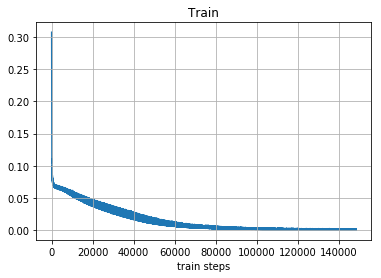

 93%|█████████▎| 6891/7422 [25:23<01:56,  4.58it/s]

Buffered data was truncated after reaching the output size limit.

In [0]:
# 3 + 6 + 15 + 6 + 10
train(dataset, test_batches, encoder1, encoder2, attn_decoder1, encoder_optimizer, decoder_optimizer, encoder_f_optimizer, 20, plot_losses=checkpoint['plot_losses'])

In [0]:
torch.save({
    'encoder1_state_dict': encoder1.state_dict(),
    'encoder2_state_dict': encoder2.state_dict(),
    'attn_decoder1_state_dict': attn_decoder1.state_dict(),
    'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
    'encoder_f_optimizer_state_dict': encoder_f_optimizer.state_dict(),
    'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
    }, "drive/diploma/two_encoders_new/Adamfinal_model_0987")

In [0]:
checkpoint = torch.load("drive/diploma/two_encoders_new/ADAM_two_encoders_unidir_GRU_9")
encoder1.load_state_dict(checkpoint['encoder1_state_dict'])
encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])

encoder2.load_state_dict(checkpoint['encoder2_state_dict'])
encoder_f_optimizer.load_state_dict(checkpoint['encoder_f_optimizer_state_dict'])


attn_decoder1.load_state_dict(checkpoint['attn_decoder1_state_dict'])
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])


100%|██████████| 1860/1860 [03:50<00:00,  8.07it/s]


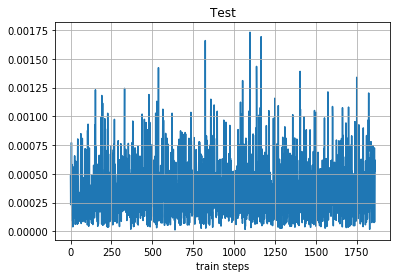

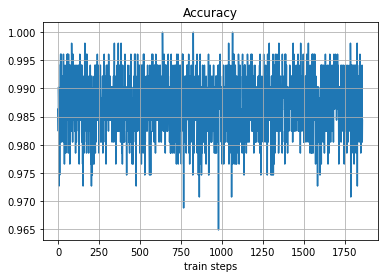

Mean accuracy - 0.9873225386424731


[0.00048562936717644334,
 0.00023239354777615517,
 0.00041498063364997506,
 0.00028690590988844633,
 0.00026496738428249955,
 0.000771010119933635,
 0.0007672806968912482,
 0.00022306398022919893,
 0.00013850786490365863,
 0.0002995958784595132,
 0.0005799595382995903,
 8.976379467640072e-05,
 0.0003759798710234463,
 0.00010655493679223582,
 3.8609963667113334e-05,
 0.00015418572002090514,
 0.00011813067249022424,
 0.0002900941763073206,
 0.00021942077728454024,
 0.0001293376844841987,
 0.0002360900107305497,
 0.0005599145079031587,
 0.0002798591158352792,
 0.0005551247741095722,
 0.00040396073018200696,
 0.0006562875933013856,
 0.00011210743105039,
 0.00036321592051535845,
 0.0002793650492094457,
 5.998218330205418e-05,
 0.00012043265451211482,
 0.0006113715935498476,
 0.0003249424626119435,
 8.656499994685873e-05,
 0.00032963004196062684,
 0.00040464772609993815,
 0.0006023164605721831,
 0.00012492178939282894,
 0.00030222334316931665,
 0.0005037942319177091,
 0.0003893717366736382,


In [0]:
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, encoder2, attn_decoder1, criterion, test_batches, loss_log, acc_log)




In [0]:
def test_att(encoder, encoder_f, decoder, criterion, batch, loss_log, acc_log):
    encoder.eval()
    encoder_f.eval()
    decoder.eval()
    res_att = []
    res_words = []
    encoder_hidden = encoder.initHidden()
    encoder_hidden_f = encoder_f.initHidden()
    max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
    X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
    X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
    y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)

    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    encoder_outputs_f = torch.zeros(BATCH_SIZE, 11, encoder.hidden_size, device=device)
    decoder_attentions = torch.zeros(BATCH_SIZE, max_length, max_length)
    decoder_attentions_morph = torch.zeros(BATCH_SIZE, max_length, 11)
    loss = 0
    acc = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]

    for i in range(X_f.shape[1]):
        encoder_output_f, encoder_hidden_f = encoder_f(
            X_f[:, i], encoder_hidden_f)
        encoder_outputs_f[:, i] = encoder_output_f[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden
    decoder_pred = []
    for di in range(y.shape[1]):
        decoder_output, decoder_hidden, decoder_attention, decoder_attention_morph = decoder(
            decoder_input, X_f, encoder_outputs_f, encoder_hidden_f, decoder_hidden, encoder_outputs)
        decoder_attentions[:, di] = decoder_attention.data
        decoder_attentions_morph[:, di] = decoder_attention_morph.data
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        loss += criterion(decoder_output, y[:, di])
        decoder_pred.append(decoder_input.cpu())
    res = np.vstack(decoder_pred).T
    pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
    true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
    res_words.append(pred_res)
    res_att.append(decoder_attentions)
    return res_words, res_att, decoder_attentions_morph
  
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(input_sentence, rotation=90, fontsize=30)
    ax.set_yticklabels(start_token + output_words, fontsize=30)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
loss_log = []
acc_log = []
criterion = nn.NLLLoss()

  0%|          | 1/1860 [00:00<03:17,  9.40it/s]

X ('_усладился#', '_закрапан#', '_реченский#', '_хамза#', '_шалый#', '_замусоривающийся#', '_пришибаемый#', '_избной#', '_антисегнетоэлектрический#', '_импровизирующий#', '_перемахнувший#', '_приласкавший#', '_францисковна#', '_взвывавший#', '_аукнувший#', '_фрезеровальный#', '_адекват#', '_скоморошный#', '_засалившийся#', '_отвоженный#', '_трухлявящийся#', '_поспевший#', '_абанский#', '_распатроненный#', '_избежавший#', '_ромазанович#', '_создающий#', '_мазияевич#', '_драгоманский#', '_намазывавший#', '_уплатнее#', '_общестроительный#', '_даниелевна#', '_подщелачивавший#', '_умасливающий#', '_долготерпеливый#', '_филумения#', '_переученный#', '_изодинамический#', '_многополюсный#', '_вознограждавшийся#', '_отстроил#', '_председательствующий#', '_плосколицый#', '_замёрз#', '_похристосовавшийся#', '_ниспадавший#', '_конституировавший#', '_лисий#', '_цефалический#', '_кареглазый#', '_скирдовальщик#', '_подпудривший#', '_венерологический#', '_виноградовский#', '_присмирявшийся#', '_широко

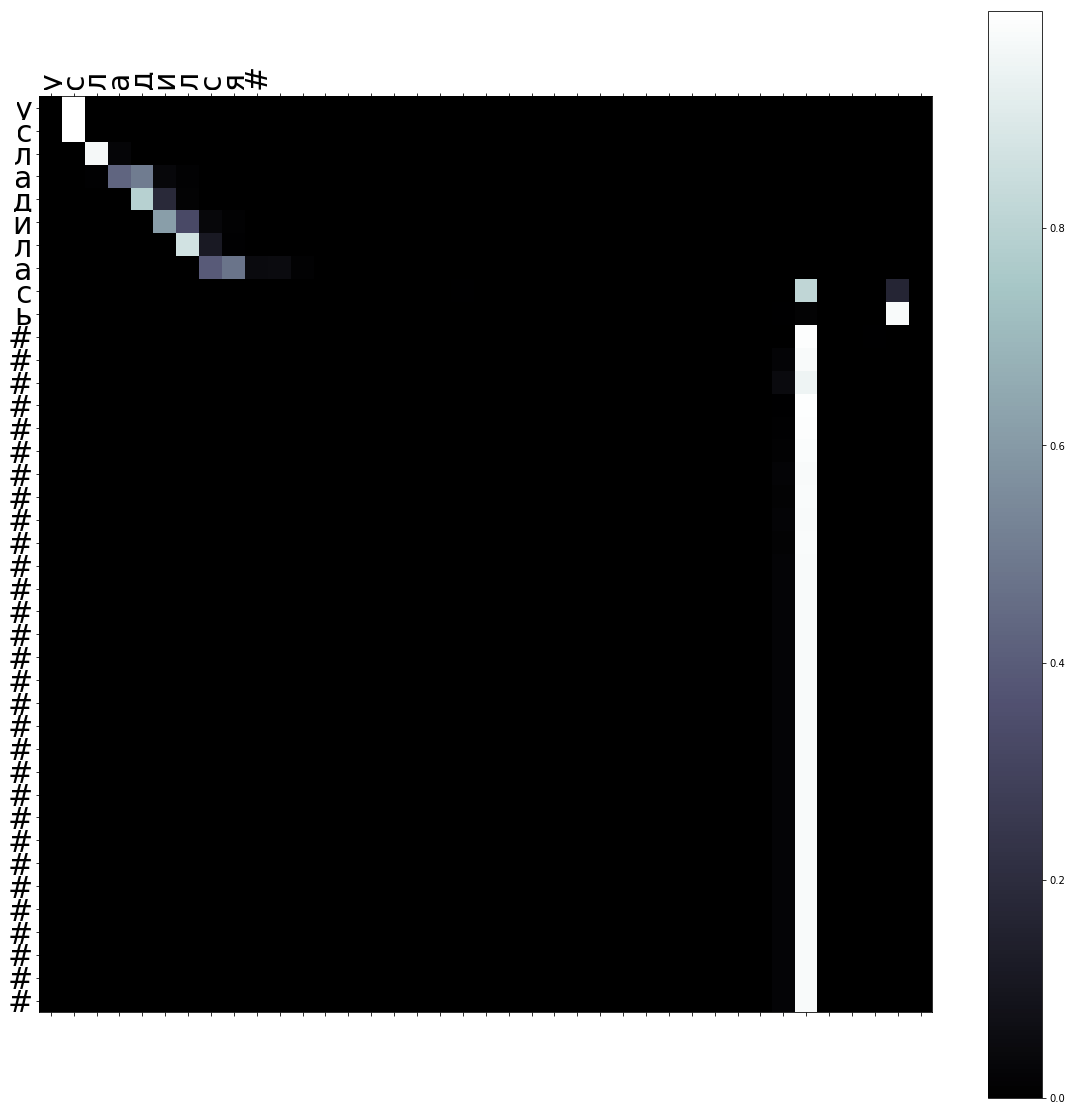

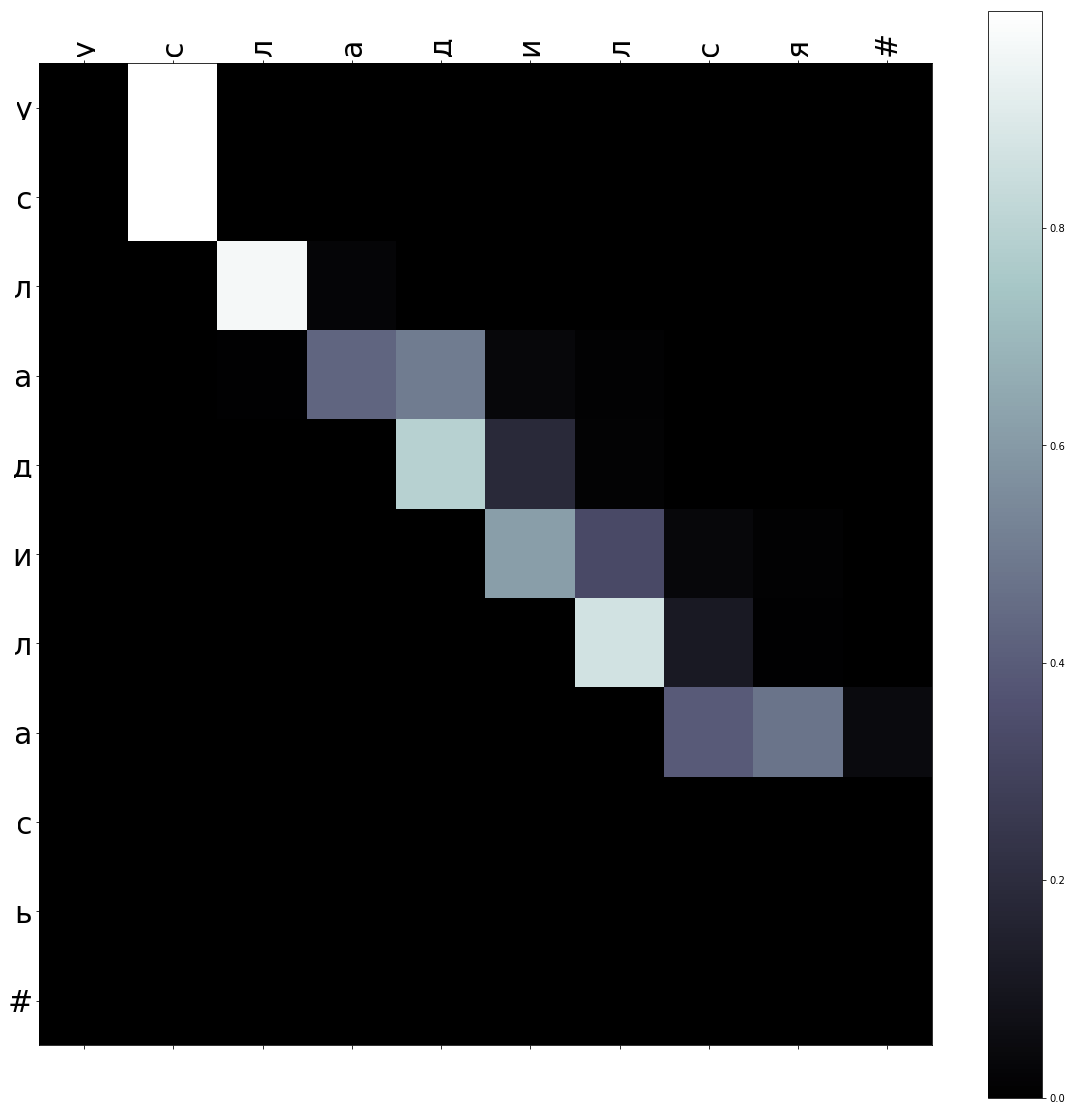

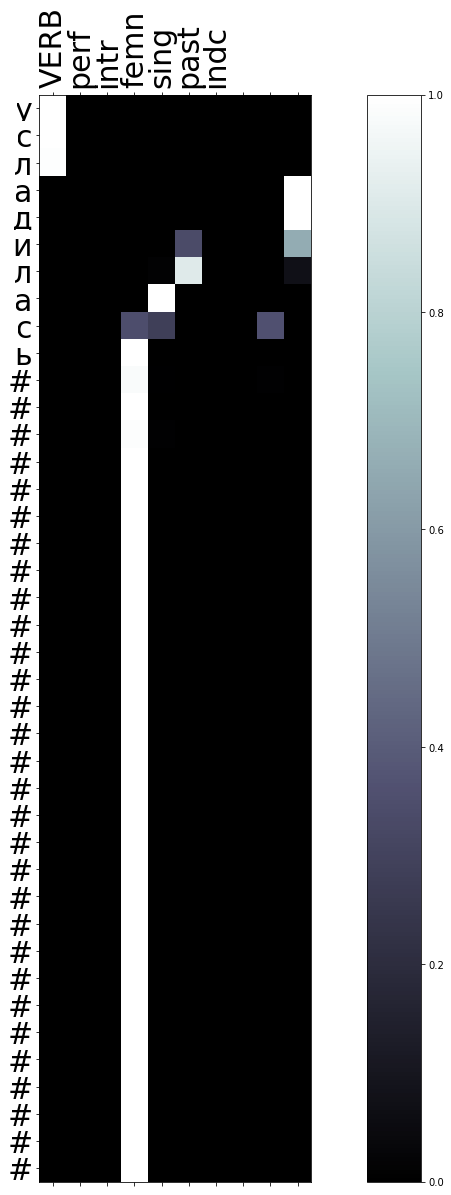

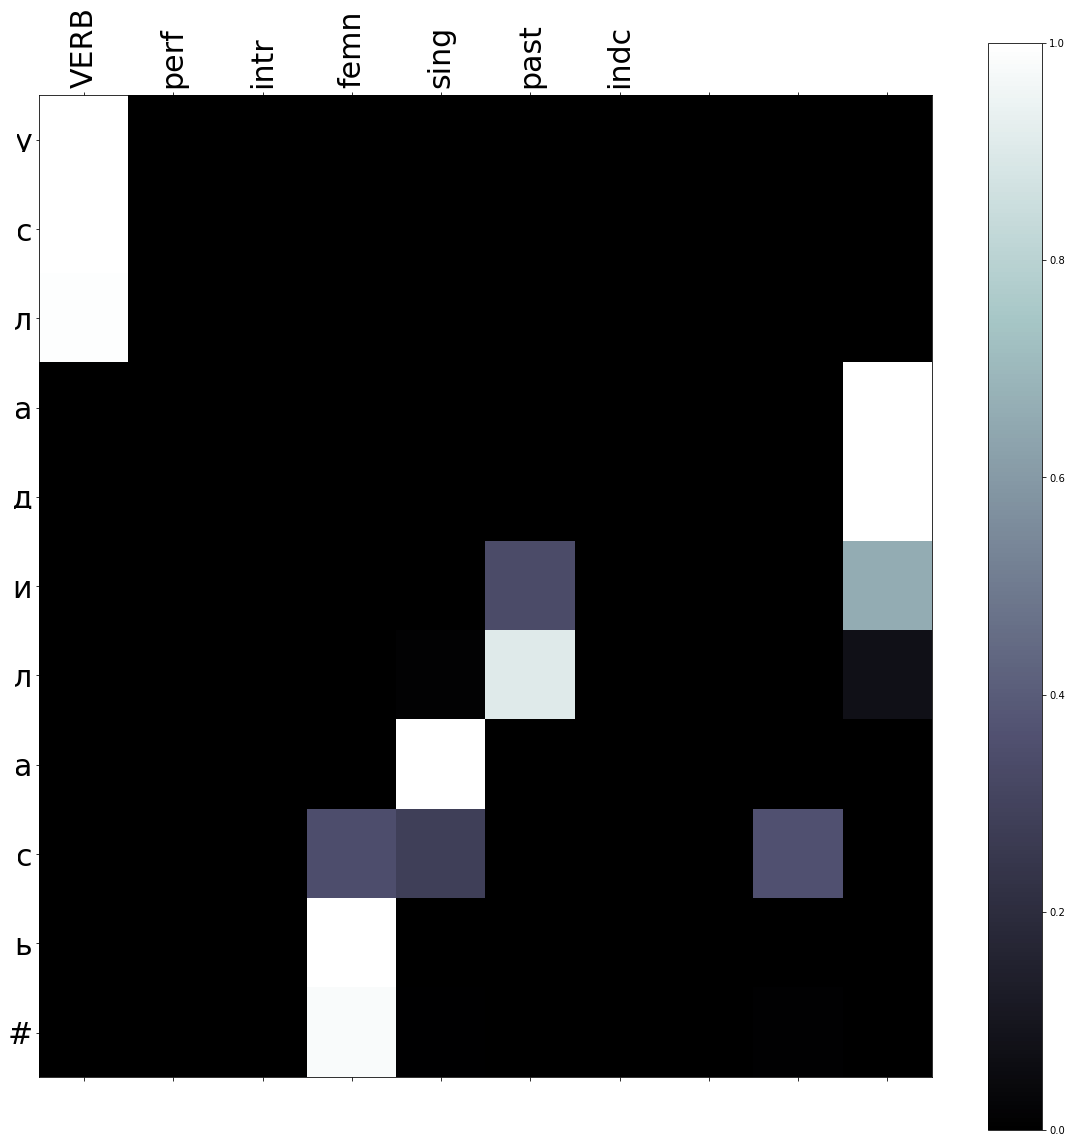

  0%|          | 2/1860 [00:03<33:47,  1.09s/it]

Norm features VERB,perf,intr masc,sing,past,indc
X ('_отсученный#', '_идейный#', '_падавший#', '_отмыкающий#', '_неразделочный#', '_тарахтящий#', '_конвективный#', '_бередимый#', '_завяливший#', '_каролингский#', '_науродовавший#', '_писун#', '_подолянин#', '_чревоугодник#', '_передерживающий#', '_припасливый#', '_линолеумов#', '_расселяющий#', '_абдулджалиловна#', '_концентрат#', '_израилевна#', '_увёртываемый#', '_настаивавший#', '_талимарджан#', '_погубивший#', '_утаптывающийся#', '_отвешивающийся#', '_натирщик#', '_кошённый#', '_андреана#', '_приталкиваю#', '_разочаровавший#', '_поумствовавший#', '_прогнувшийся#', '_ножонка#', '_заругавшийся#', '_фристайлист#', '_выбегался#', '_подвинувшийся#', '_психопатологический#', '_пролёжка#', '_тупоносый#', '_виоланта#', '_среднеотраслевой#', '_припахал#', '_авалировавшийся#', '_успешный#', '_верхнеплосковский#', '_расклёвывая#', '_перепалывающий#', '_головорез#', '_столп#', '_прозябание#', '_ветрогенератор#', '_треснутый#', '_спецналог#', '

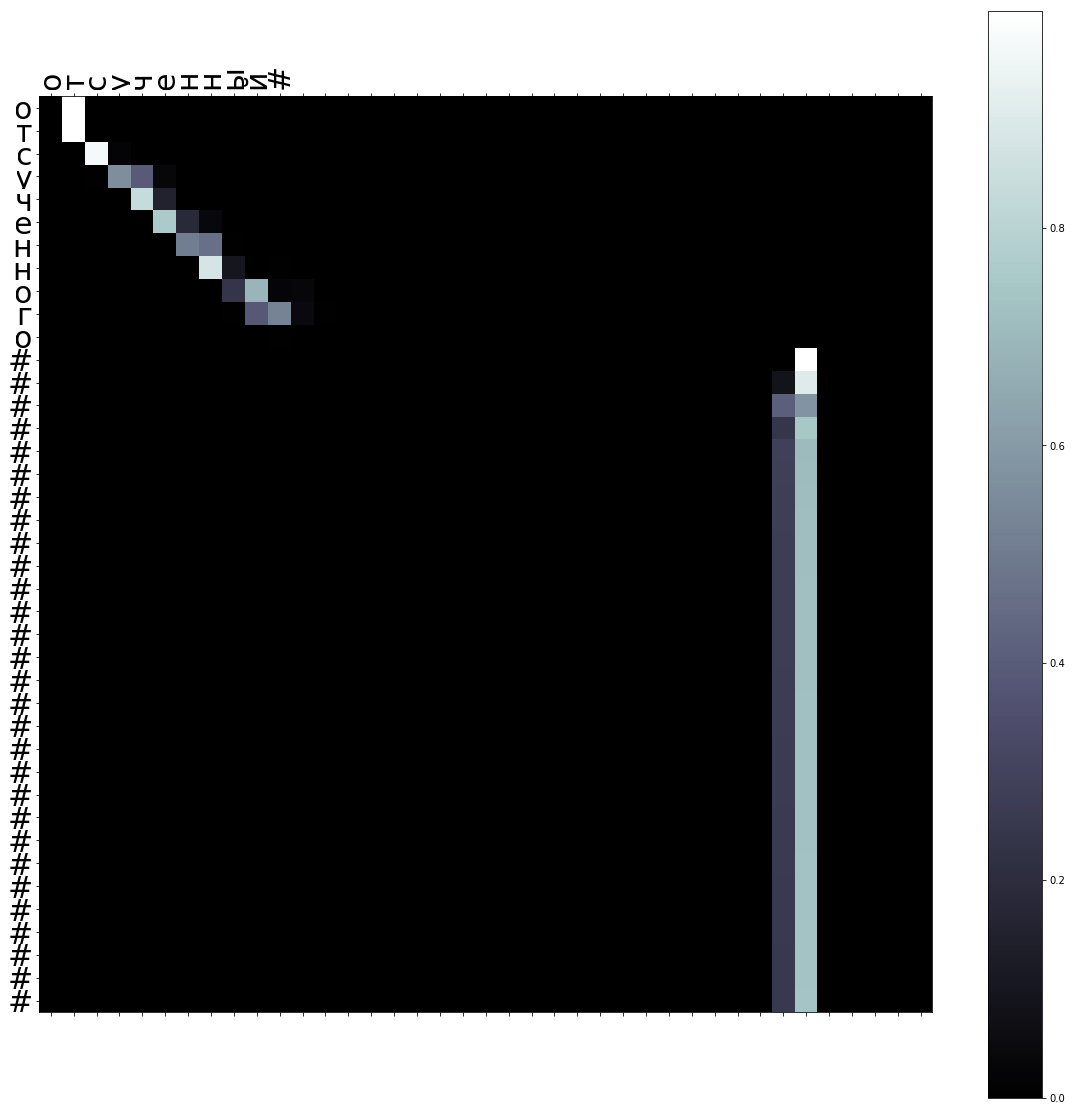

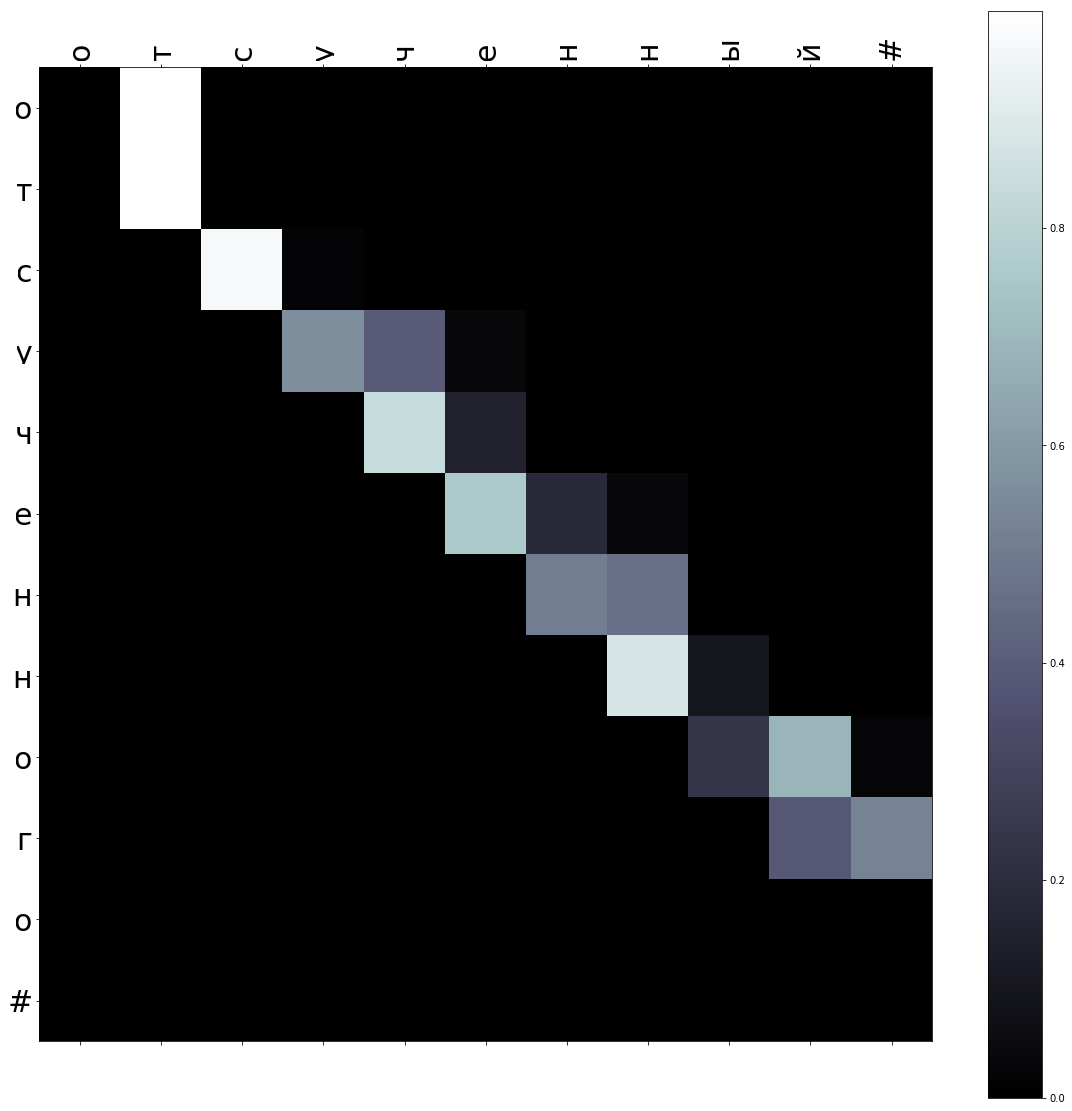

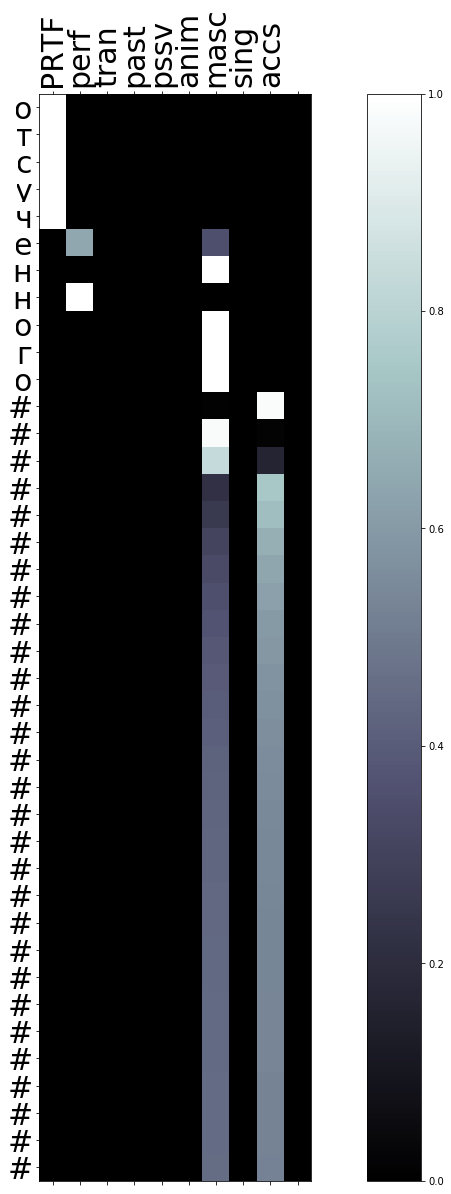

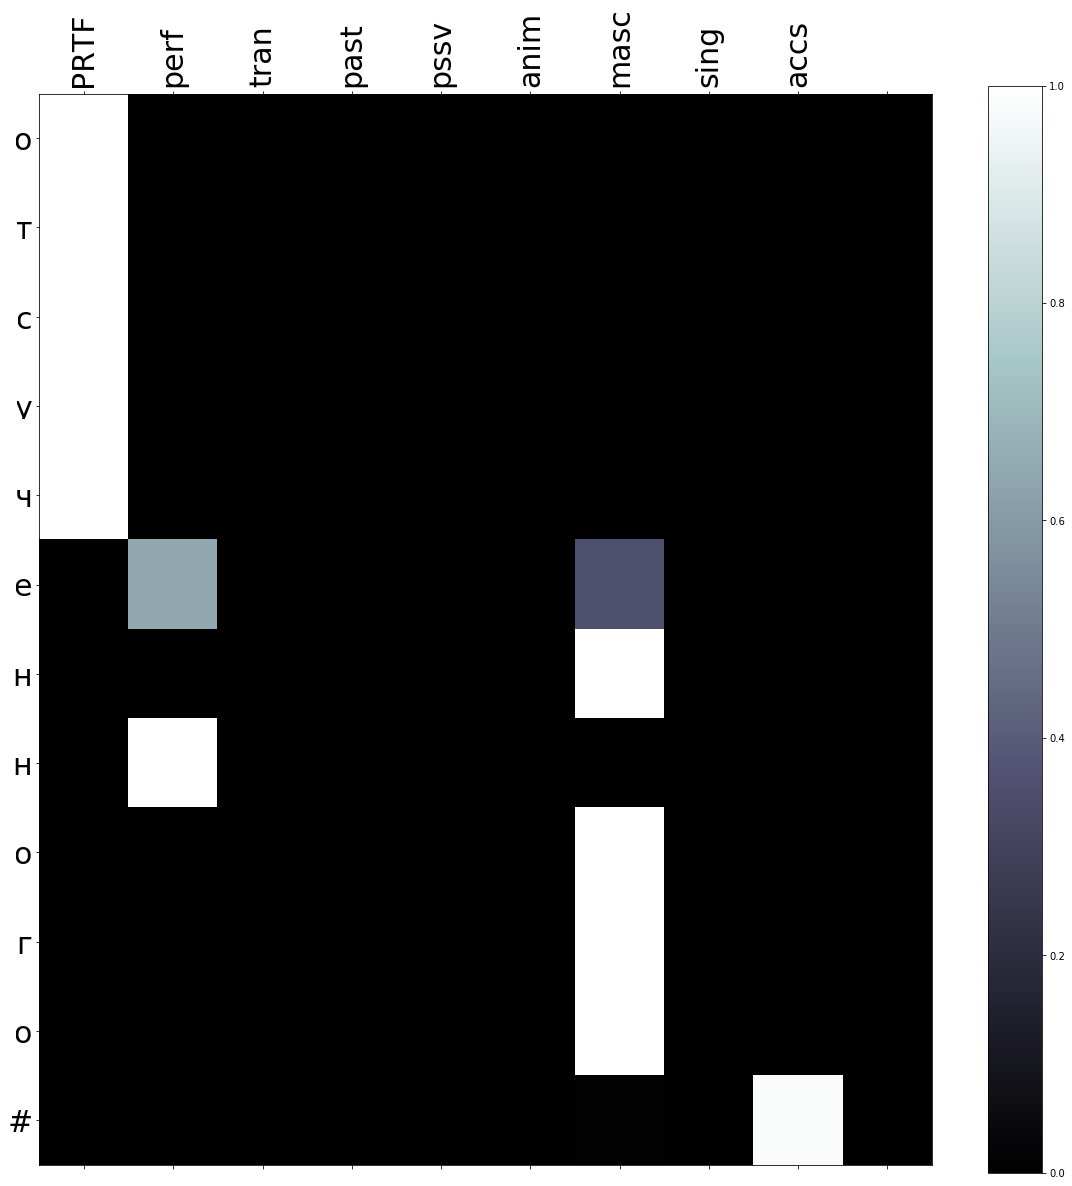

  0%|          | 3/1860 [00:06<55:24,  1.79s/it]

Norm features PRTF,perf,tran,past,pssv masc,sing,nomn
X ('_биомедпрепарат#', '_врачебный#', '_натёк#', '_перегруппировывающийся#', '_покорявший#', '_забастовавший#', '_обсушивание#', '_процессуальнее#', '_колоколова#', '_разнообразя#', '_наушник#', '_отрясавшийся#', '_шестисотлетие#', '_дегустировавший#', '_полировка#', '_отчеканивая#', '_фотоэлектрический#', '_томислав#', '_человеко-час#', '_фебрильный#', '_вертевшийся#', '_пробрюзжал#', '_аппретируемый#', '_обслюниваемый#', '_бурятзолото#', '_томаровна#', '_эмулировавшийся#', '_белковина#', '_плакатист#', '_дополол#', '_отписывающийся#', '_венерик#', '_молодивший#', '_накачиваюсь#', '_лексикологический#', '_диадический#', '_изощрившийся#', '_религиозно-этический#', '_побивающийся#', '_соскабливаюсь#', '_пригладил#', '_противосолнце#', '_возмущавший#', '_благополучен#', '_дикарка#', '_опричный#', '_электросталеплавильный#', '_выпрягаемый#', '_неисчерпанный#', '_поорал#', '_личинный#', '_безличный#', '_злоупотребляю#', '_подрыгиваю#', 

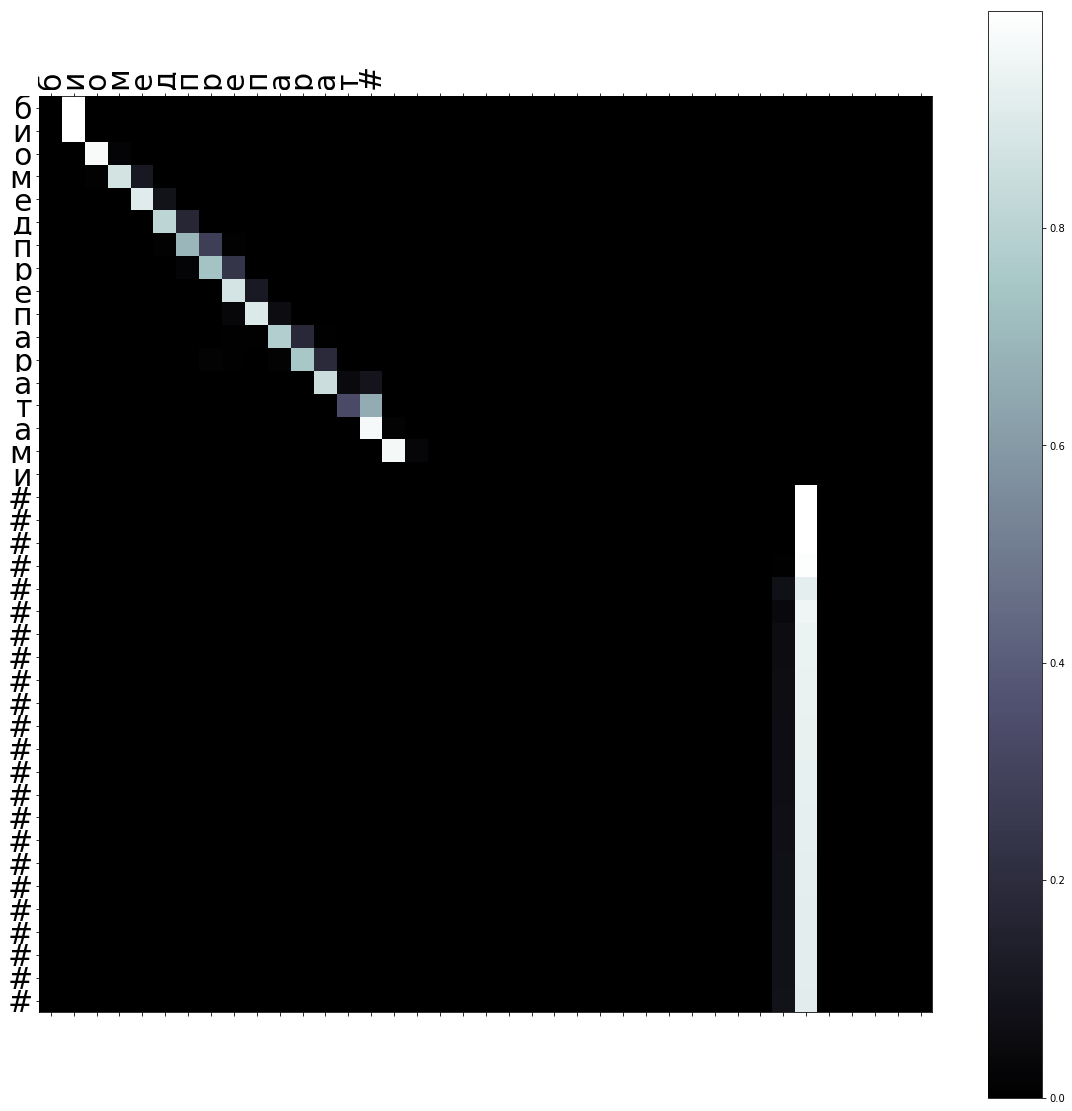

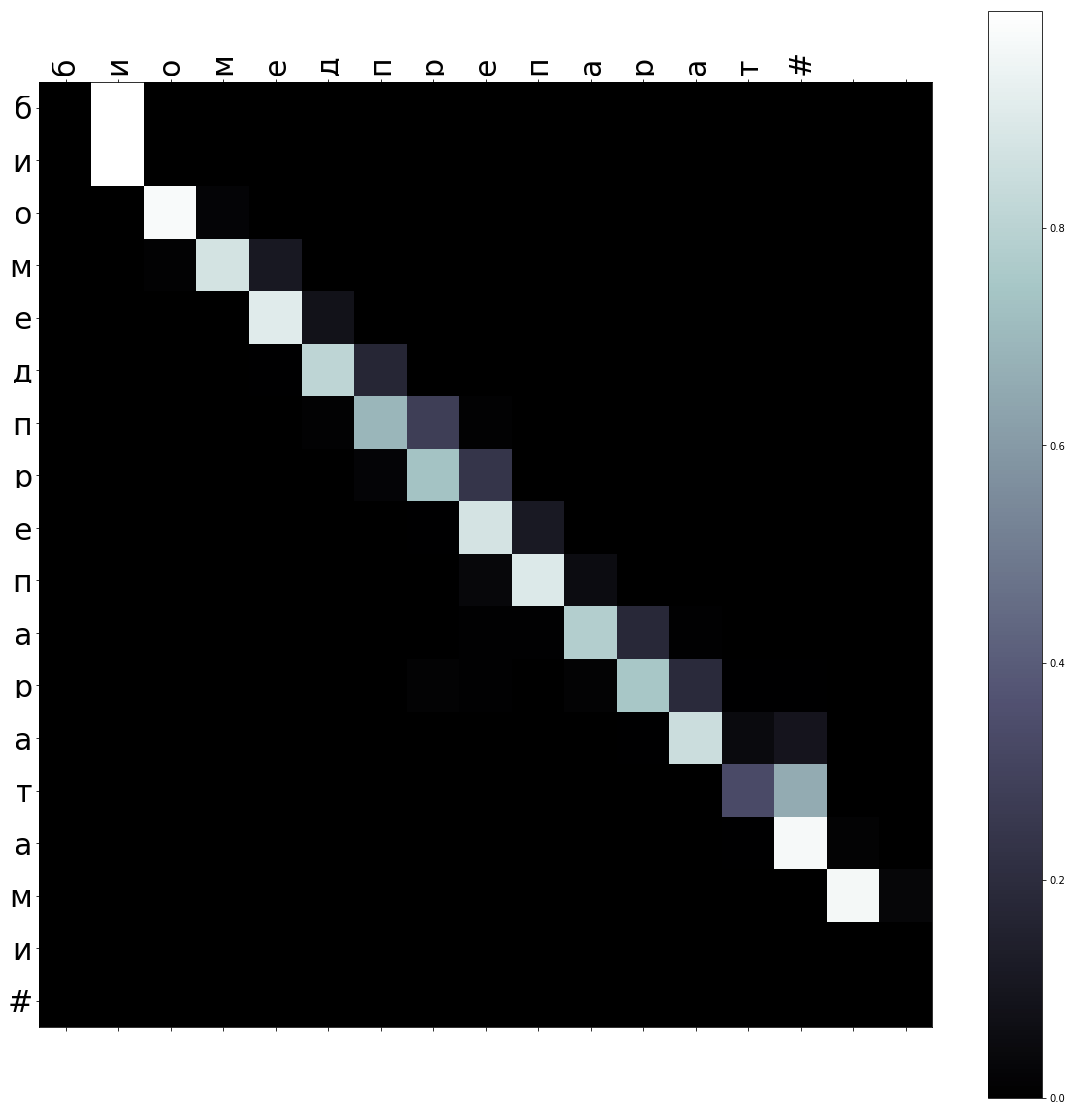

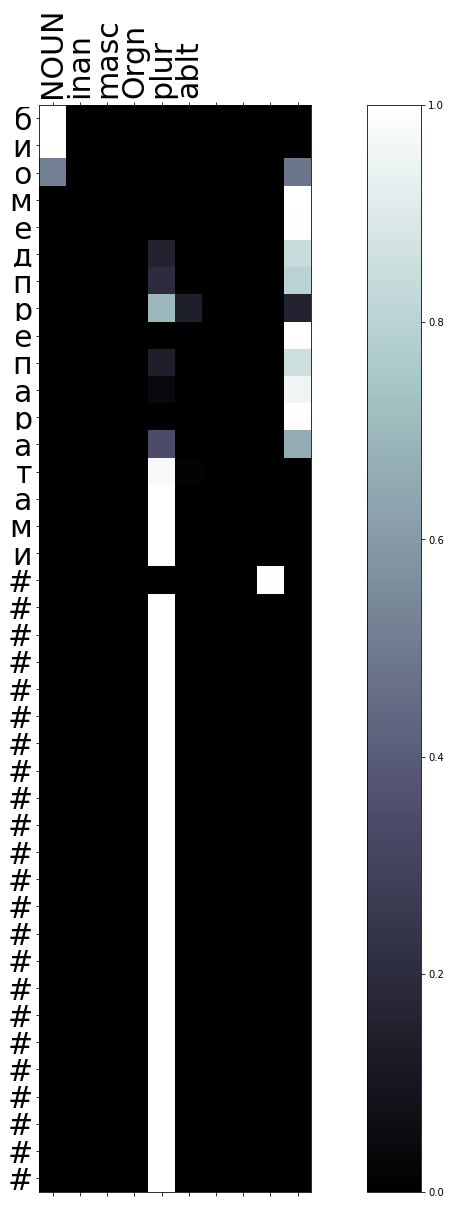

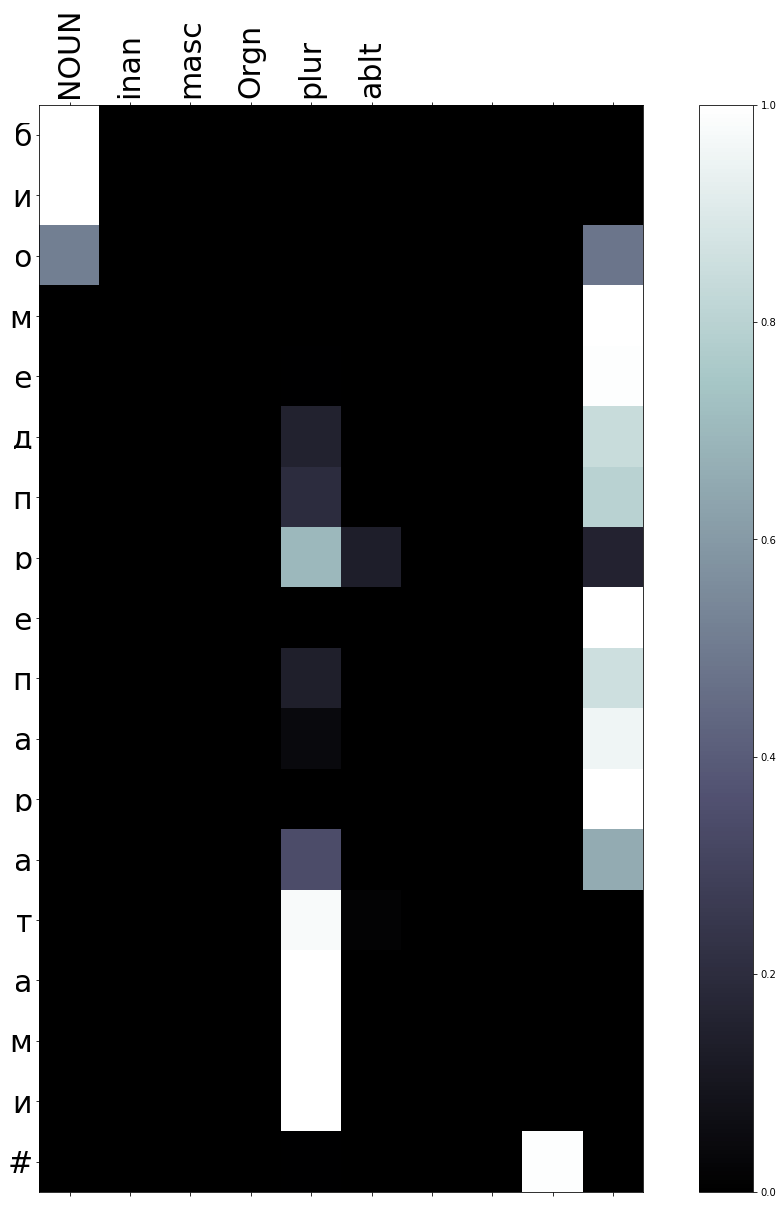

  1%|          | 20/1860 [00:10<34:22,  1.12s/it]

Norm features NOUN,inan,masc,Orgn sing,nomn


100%|██████████| 1860/1860 [00:30<00:00, 60.11it/s]


In [0]:
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
  if batch_num == 1 or batch_num == 2 or batch_num == 3:
    res_words, decoder_attentions, decoder_attentions_morph  = test_att(encoder1, encoder2, attn_decoder1, criterion, batch, loss_log, acc_log)
    print("X {}".format(batch[0]))
    print("res_word {}".format(res_words[0]))
    print(decoder_attentions[0].shape)
    showAttention(batch[0][0], res_words[0][0], decoder_attentions[0][0][:, 1:])
    ind = 0
    for i, elem in enumerate(res_words[0][0]):
      if elem == "#":
        ind = i
        break
    showAttention(batch[0][0], res_words[0][0][:ind + 1], decoder_attentions[0][0][:ind + 1, 1:ind + 1])
    
    showAttention([start_token] + re.split(",| ", batch[1][0]), res_words[0][0], decoder_attentions_morph[0][:, 1:])
    showAttention([start_token] + re.split(",| ", batch[1][0]), res_words[0][0][:ind + 1], decoder_attentions_morph[0][:ind + 1, 1:ind + 1])
    print("Norm features", batch[3][0])

In [0]:
mistakes = pd.DataFrame()
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
    res_words, decoder_attentions, _ = test_att(encoder1, encoder2, attn_decoder1, criterion, batch, loss_log, acc_log)
    y = to_matrix(batch[2], max_len=MAX_LENGTH)
    true_res = ["".join(id2tok[_] for _ in y[i]) for i in range(y.shape[0])]
    res_words = np.array(res_words[0])
    true_res = np.array(true_res)
    ret_res = np.copy(res_words)
    for j in range(ret_res.shape[0]):
      for i, elem in enumerate(ret_res[j]):
            if elem == "#":
              ret_res[j] = ret_res[j][:i] 
    y_ret = np.array(batch[2])
    for i, word in enumerate(y_ret):
      y_ret[i] = word[:-1]
    d = {"norm_form":np.array(batch[0])[res_words != true_res], "True label":y_ret[res_words != true_res], "Predicted":ret_res[res_words != true_res], "Norm morph features":np.array(batch[3])[res_words != true_res], "Transformed morph features":np.array(batch[1])[res_words != true_res]}
    mistakes = pd.concat([mistakes, pd.DataFrame(data=d)])  


100%|██████████| 1860/1860 [05:09<00:00,  5.91it/s]


In [0]:
mistakes.head(100)

,norm_form,True label,Predicted,Norm morph features,Transformed morph features
0,_индивидуально-определенен#,индивидуально-определенно,индивидуально-определьно,"ADJS masc,sing,V-en","ADJS neut,sing"
1,_строённый#,строенных,строённых,"PRTF,perf,tran,past,pssv masc,sing,nomn,Infr","PRTF,perf,tran,past,pssv anim,plur,accs"
2,_поохал#,поохаем,поошем,"VERB,perf,intr masc,sing,past,indc","VERB,perf,intr plur,1per,futr,indc"
3,_плачу#,плачут,плачат,"VERB,impf,intr sing,1per,pres,indc","VERB,impf,intr plur,3per,pres,indc"
4,_беллендиры#,беллендиров,беллендирых,"NOUN,anim,ms-f,Pltm,Surn plur,nomn","NOUN,anim,ms-f,Pltm,Surn plur,accs"
5,_заскирдовал#,заскирдуем,заскиддуем,"VERB,perf,tran masc,sing,past,indc","VERB,perf,tran plur,1per,futr,indc"
6,_кетой#,кетоя,кетого,"NOUN,inan,masc,Sgtm,Geox sing,nomn","NOUN,inan,masc,Sgtm,Geox sing,gent"
7,_чурчхела#,чурчхели,чурчхелы,"NOUN,inan,femn sing,nomn","NOUN,inan,femn plur,nomn,Infr"
8,_волынцы#,волынцов,волынцев,"NOUN,anim,ms-f,Pltm,Surn plur,nomn","NOUN,anim,ms-f,Pltm,Surn plur,accs"
0,_кочевряжусь#,кочевряжься,кочеврязься,"VERB,impf,intr sing,1per,pres,indc","VERB,impf,intr sing,impr,excl"


In [0]:
mistakes.to_csv("drive/diploma/mistakes/mistake_model_two_attentions.csv")

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs_new.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x:  x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
BATCH_SIZE = 512

input_data = data_pairs.drop("word_form", axis=1)
target = data_pairs.word_form.values

input_data = pairs_Dataset(input_data, target)
dataset_full = DataLoader(input_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

100%|██████████| 18566/18566 [37:57<00:00,  8.39it/s]


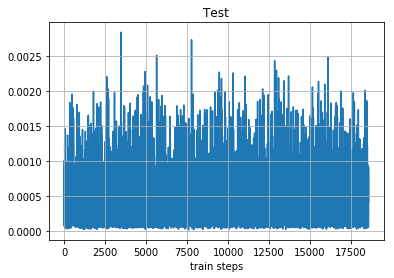

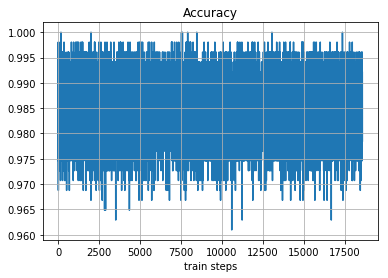

Mean accuracy - 0.9854276213912528


[0.000365681538823992,
 0.0001736973354127258,
 0.00033212045673280954,
 0.00016909383703023195,
 0.00013094230962451547,
 0.00019567098934203386,
 7.742451271042228e-05,
 0.00012100501771783456,
 0.0008212181855924428,
 0.001010016305372119,
 0.00012377649545669556,
 0.00010206449223915115,
 0.00011614839604590088,
 7.342961907852441e-05,
 0.0005140876746736467,
 0.0002335908793611452,
 0.0009115963475778699,
 0.00042416551150381565,
 0.0003740541869774461,
 0.00034604762913659215,
 0.000749718863517046,
 0.000156163951032795,
 0.0008937735692597926,
 0.0004504079115577042,
 0.0006492785178124905,
 0.00012399136903695762,
 0.0004823512281291187,
 0.0005805453401990235,
 0.0003462387539912015,
 9.876391413854435e-05,
 0.00023846501426305622,
 0.0007546342676505446,
 0.00045229343231767416,
 0.001244163722731173,
 0.000256878265645355,
 0.0001413012359989807,
 0.00014081853441894054,
 0.0001246776373591274,
 0.00011503378482302651,
 0.00020597748516593128,
 0.0006635378813371062,
 4.693

In [0]:
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, encoder2, attn_decoder1, criterion, dataset_full, loss_log, acc_log)


In [0]:
!pip install pymorphy2

    100% |████████████████████████████████| 51kB 6.5MB/s 
    100% |████████████████████████████████| 7.1MB 5.1MB/s 


100%|██████████| 1860/1860 [05:32<00:00,  5.73it/s]


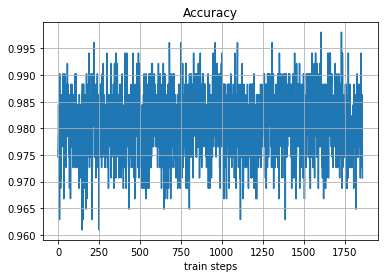

Mean accuracy - 0.9812920026881721


In [0]:

import pymorphy2

acc_log = []
morph = pymorphy2.MorphAnalyzer()
t = 0
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
  X = batch[0]
  X_f = np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))])
  y = batch[2]
  norm_form = np.array([re.split(",| ", batch[3][i]) for i in range(len(batch[1]))])
  acc = 0
  neg_acc = 0
  for i in range(len(X)):
    py_lemmas = morph.parse(X[i][1:-1])
    morph_set = set(X_f[i])
    py_lemma = 0
    if "ms-f" in norm_form[i]:
      for j, elem in enumerate(norm_form[i]):
        if elem == "ms-f":
          norm_form[i][j] = "Ms-f"
    for p_lem in py_lemmas:
      if set(norm_form[i]) in p_lem.tag:
        py_lemma = p_lem
    try: 
      pred = py_lemma.inflect(morph_set).word
    except:
      t += 1
      
    acc += pred == y[i][1:-1]
#     print("pred", pred)
#     print("target", y[i][1:-1])
#     print("Norm", X[i][1:-1])
#     print("Norm features", set(norm_form[i]))
    neg_acc += pred != y[i][1:-1]
  acc_log.append(acc / (acc + neg_acc))
plot_history(acc_log, title="Accuracy")
print("Mean accuracy - {}".format(np.mean(acc_log)))